## Importing Libraries

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

## Importing the Data

In [5]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data() #Ignoring Labels as we are performing Reconstruction
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255. #Normalizing the data
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

## Encoder

In [6]:
class Encoder(layers.Layer):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.d = layers.Dense(latent_dim + latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.d(x)
        return x

## Decoder

In [7]:
class Decoder(layers.Layer):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(7*7*64, activation='relu')
        self.reshape = layers.Reshape((7, 7, 64))
        self.convT1 = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')
        self.convT2 = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')
        self.convT3 = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.convT1(z)
        z = self.convT2(z)
        z = self.convT3(z)
        return z

## Reparametrization

In [8]:
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, x):
        encoded = self.encoder(x)
        z_mean, z_log_var = tf.split(encoded, num_or_size_splits=2, axis=1)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss 
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        kl_coefficient = 0.001  # Got this through experimentation with various values
        self.add_loss(kl_coefficient * kl_loss)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return eps * tf.exp(z_log_var * .5) + z_mean

## Plotting Images

In [9]:
def plot_images(original, reconstructed, latent_dim):
    n = 5 # Number of digits to display
    plt.figure(figsize=(20, 6))
    title = f'Latent Dimensions: {latent_dim}'
    plt.suptitle(title, fontsize=20)
    for i in range(n):
        # Show original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.title("Test Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Show reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28))
        plt.title("Test Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## VAE with 2 Latent Dimensions

In [10]:
latent_dim = 2
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

2024-03-05 16:36:02.563836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
938/938 [==============================] - 72s 75ms/step - loss: 0.0621 - val_loss: 0.0531
Epoch 2/10
938/938 [==============================] - 69s 74ms/step - loss: 0.0514 - val_loss: 0.0505
Epoch 3/10
938/938 [==============================] - 73s 77ms/step - loss: 0.0494 - val_loss: 0.0489
Epoch 4/10
938/938 [==============================] - 67s 71ms/step - loss: 0.0482 - val_loss: 0.0482
Epoch 5/10
938/938 [==============================] - 52s 56ms/step - loss: 0.0476 - val_loss: 0.0473
Epoch 6/10
938/938 [==============================] - 57s 61ms/step - loss: 0.0471 - val_loss: 0.0470
Epoch 7/10
938/938 [==============================] - 71s 76ms/step - loss: 0.0468 - val_loss: 0.0470
Epoch 8/10
938/938 [==============================] - 72s 77ms/step - loss: 0.0464 - val_loss: 0.0465
Epoch 9/10
938/938 [==============================] - 76s 81ms/step - loss: 0.0462 - val_loss: 0.0465
Epoch 10/10
938/938 [==============================] - 74s 78ms/step - loss: 0.046

In [11]:
predictions = vae.predict(x_test)
mse1 = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse1)

313/313 [==============================] - 5s 15ms/step
Test MSE: 0.043445904


157/157 [==============================] - 4s 27ms/step


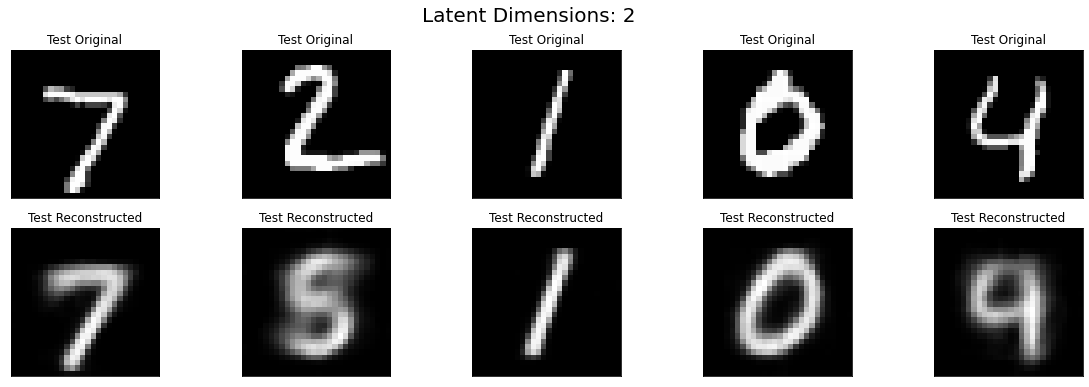

In [12]:
# Recontructed images with 2 latent dimensions
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 4 Latent Dimensions

In [13]:
latent_dim = 4
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10


938/938 [==============================] - 76s 80ms/step - loss: 0.0517 - val_loss: 0.0379
Epoch 2/10
938/938 [==============================] - 73s 78ms/step - loss: 0.0365 - val_loss: 0.0352
Epoch 3/10
938/938 [==============================] - 72s 76ms/step - loss: 0.0348 - val_loss: 0.0342
Epoch 4/10
938/938 [==============================] - 78s 83ms/step - loss: 0.0339 - val_loss: 0.0336
Epoch 5/10
938/938 [==============================] - 79s 84ms/step - loss: 0.0333 - val_loss: 0.0333
Epoch 6/10
938/938 [==============================] - 76s 82ms/step - loss: 0.0329 - val_loss: 0.0332
Epoch 7/10
938/938 [==============================] - 78s 83ms/step - loss: 0.0326 - val_loss: 0.0326
Epoch 8/10
938/938 [==============================] - 76s 81ms/step - loss: 0.0323 - val_loss: 0.0325
Epoch 9/10
938/938 [==============================] - 80s 86ms/step - loss: 0.0321 - val_loss: 0.0325
Epoch 10/10
938/938 [==============================] - 71s 76ms/step - loss: 0.0319 - val_los

In [14]:
predictions = vae.predict(x_test)
mse2 = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse2)

313/313 [==============================] - 5s 14ms/step
Test MSE: 0.029310841


157/157 [==============================] - 4s 24ms/step


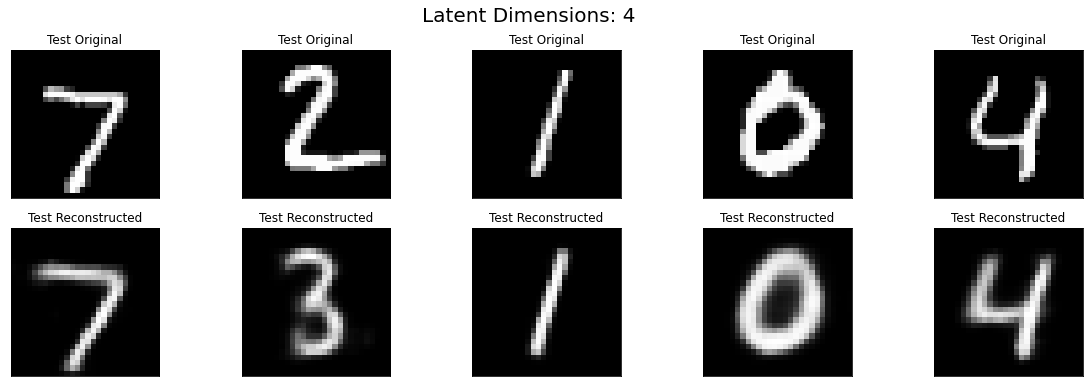

In [15]:
# Recontructed images with 4 latent dimensions
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 8 Latent Dimensions

In [16]:
latent_dim = 8
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 74s 78ms/step - loss: 0.0388 - val_loss: 0.0240
Epoch 2/10
938/938 [==============================] - 74s 78ms/step - loss: 0.0230 - val_loss: 0.0219
Epoch 3/10
938/938 [==============================] - 92s 98ms/step - loss: 0.0214 - val_loss: 0.0207
Epoch 4/10
938/938 [==============================] - 71s 76ms/step - loss: 0.0205 - val_loss: 0.0203
Epoch 5/10
938/938 [==============================] - 68s 73ms/step - loss: 0.0199 - val_loss: 0.0197
Epoch 6/10
938/938 [==============================] - 74s 79ms/step - loss: 0.0195 - val_loss: 0.0195
Epoch 7/10
938/938 [==============================] - 74s 79ms/step - loss: 0.0192 - val_loss: 0.0190
Epoch 8/10
938/938 [==============================] - 68s 73ms/step - loss: 0.0189 - val_loss: 0.0190
Epoch 9/10
938/938 [==============================] - 82s 87ms/step - loss: 0.0187 - val_loss: 0.0190
Epoch 10/10
938/938 [==============================] - 81s 86ms/step - loss: 0.018

In [17]:
predictions = vae.predict(x_test)
mse3 = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse3)

  1/313 [..............................] - ETA: 1:32

313/313 [==============================] - 5s 15ms/step
Test MSE: 0.015848158


157/157 [==============================] - 4s 23ms/step


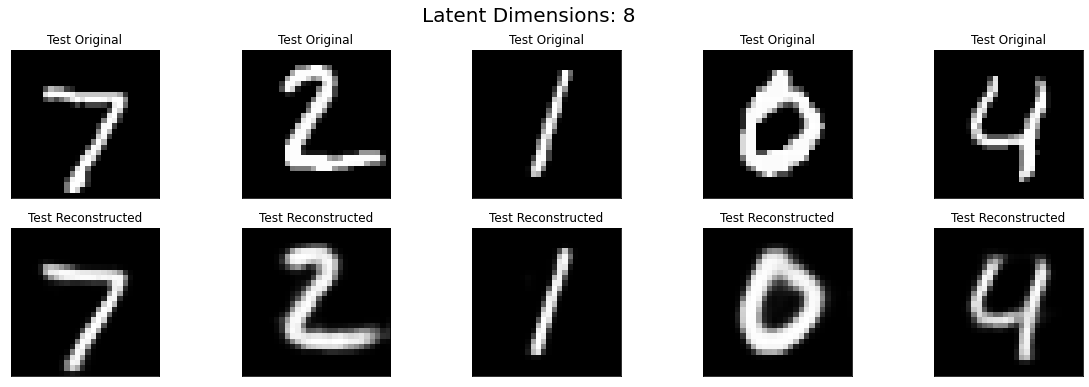

In [18]:
# Recontructed images with 8 latent dimensions
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 16 Latent Dimensions

In [19]:
latent_dim = 16
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 74s 78ms/step - loss: 0.0314 - val_loss: 0.0144
Epoch 2/10
938/938 [==============================] - 72s 77ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 3/10
938/938 [==============================] - 62s 66ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 4/10
938/938 [==============================] - 62s 66ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 5/10
938/938 [==============================] - 63s 68ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 6/10
938/938 [==============================] - 60s 64ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 7/10
938/938 [==============================] - 61s 65ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 8/10
938/938 [==============================] - 63s 67ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 9/10
938/938 [==============================] - 61s 65ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 10/10
938/938 [==============================] - 61s 65ms/step - loss: 0.010

In [20]:
predictions = vae.predict(x_test)
mse4 = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse4)

313/313 [==============================] - 4s 11ms/step
Test MSE: 0.0076776887


157/157 [==============================] - 3s 22ms/step


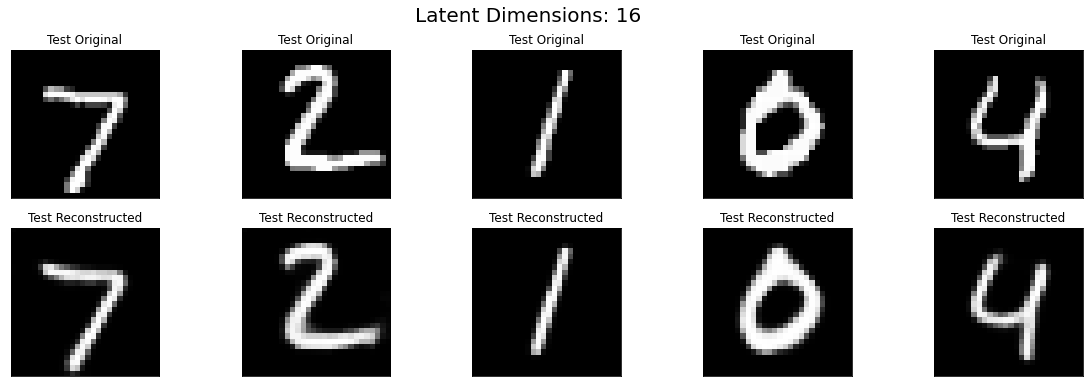

In [21]:
# Recontructed images with 16 latent dimensions
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 32 Latent Dimensions

In [22]:
latent_dim = 32
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 67s 70ms/step - loss: 0.0266 - val_loss: 0.0093
Epoch 2/10
938/938 [==============================] - 63s 67ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 3/10
938/938 [==============================] - 64s 68ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 4/10
938/938 [==============================] - 74s 79ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 5/10
938/938 [==============================] - 64s 68ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 6/10
938/938 [==============================] - 52s 56ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 7/10
938/938 [==============================] - 53s 56ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/10
938/938 [==============================] - 52s 56ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 9/10
938/938 [==============================] - 56s 60ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 10/10
938/938 [==============================] - 68s 73ms/step - loss: 0.006

In [23]:
predictions = vae.predict(x_test)
mse5 = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse5)

313/313 [==============================] - 4s 11ms/step
Test MSE: 0.003941704


157/157 [==============================] - 3s 20ms/step


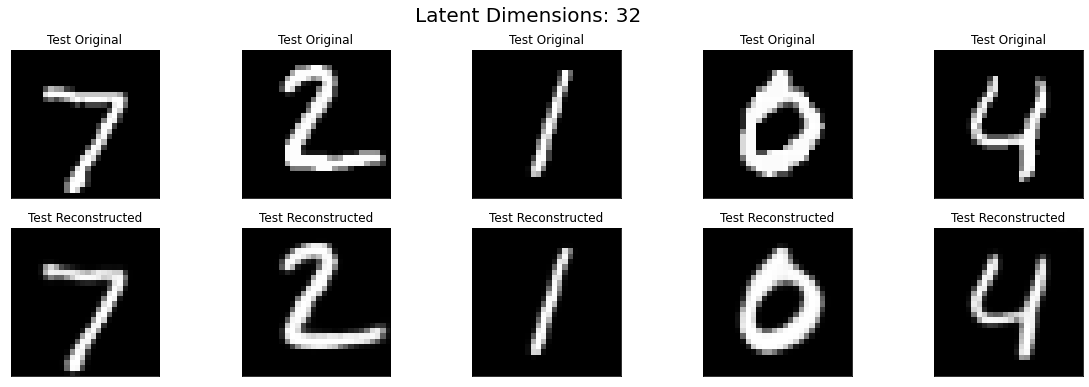

In [24]:
# Recontructed images with 32 latent dimensions
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 64 Latent Dimensions

In [25]:
latent_dim = 64
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10


938/938 [==============================] - 62s 65ms/step - loss: 0.0238 - val_loss: 0.0075
Epoch 2/10
938/938 [==============================] - 60s 64ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 3/10
938/938 [==============================] - 60s 63ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 4/10
938/938 [==============================] - 59s 63ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 5/10
938/938 [==============================] - 63s 67ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 6/10
938/938 [==============================] - 61s 65ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/10
938/938 [==============================] - 69s 73ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 8/10
938/938 [==============================] - 59s 63ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/10
938/938 [==============================] - 56s 60ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 10/10
938/938 [==============================] - 60s 64ms/step - loss: 0.0043 - val_los

In [26]:
predictions = vae.predict(x_test)
mse6 = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse6)

313/313 [==============================] - 4s 12ms/step
Test MSE: 0.0023274238


157/157 [==============================] - 3s 19ms/step


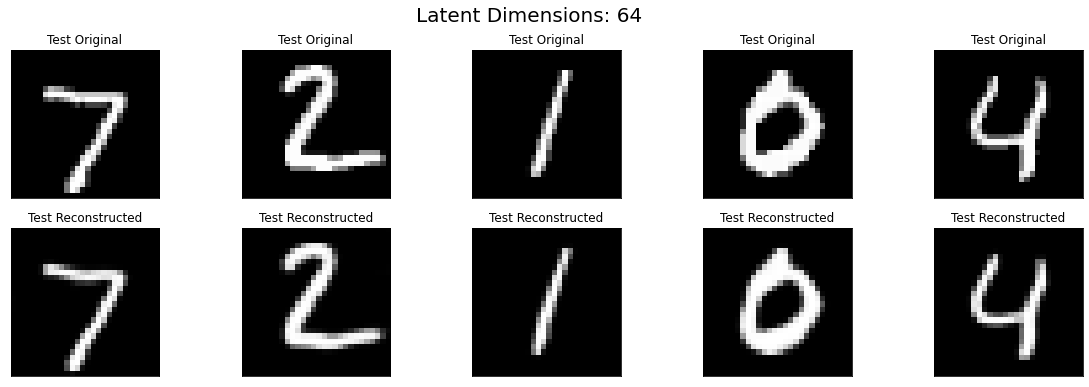

In [27]:
# Recontructed images with 64 latent dimensions
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## MSE Error 

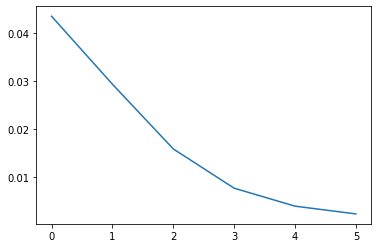

In [28]:
mse_list = [mse1, mse2, mse3, mse4, mse5, mse6]
plt.plot(mse_list) # Can clearly see the mse reduce as we increase latent dimensions